# Introduction to atomman: Dislocation analysis tools

__Lucas M. Hale__, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), _Materials Science and Engineering Division, NIST_.
    
[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm) 

## 1. Introduction

This Notebook describes the analysis tools contained in atomman.defect for finding and characterizing dislocations.

**Library Imports**

In [1]:
# Standard Python libraries
from __future__ import (absolute_import, print_function,
                        division, unicode_literals)
from copy import deepcopy
import datetime

# http://www.numpy.org/
import numpy as np

# https://matplotlib.org/
import matplotlib.pyplot as plt
%matplotlib inline

# https://github.com/usnistgov/atomman
import atomman as am
import atomman.unitconvert as uc

# Show atomman version
print('atomman version =', am.__version__)

# Show date of Notebook execution
print('Notebook executed on', datetime.date.today())

atomman version = 1.2.8
Notebook executed on 2019-07-30


## 1.1. Generate systems

The process used here for generating dislocation-containing systems is

1. Build a unit cell system.

2. Generate a defect-free reference system by rotating, shifting and supersizing the unit cell.

3. Use the Stroh class to compute the elastic solution for a perfectly straight dislocation.

4. Generate a defect-containing system by shifting atoms in the reference system by the Stroh displacements.

**Note #1**: All the analysis tools used here require a defect-free reference system in order to identify the defects in the final systems.  The system constructed in step #2 serves this purpose.

**Note #2**: The final defect systems presented here are for demonstration purposes only as no atomic relaxations are performed. 

In [2]:
# 0 K values for Al
alat = uc.set_in_units(4.05, 'Å')
C11 = uc.set_in_units(1.143e12, 'dyn/cm^2')
C12 = uc.set_in_units(0.619e12, 'dyn/cm^2')
C44 = uc.set_in_units(0.316e12, 'dyn/cm^2')

# Define properties for fcc edge dislocation system
burgers = alat / 2 * np.array([1, 0, -1])
m=[1,0,0]
n=[0,1,0]
xaxis = [ 1, 0,-1]
yaxis = [ 1, 1, 1]
zaxis = [ 1,-2, 1]
shift = alat * np.array([2**0.5 / 8, 3**0.5 / 6, 0.0])

# Generate fcc Al unit cell
box = am.Box(a=alat, b=alat, c=alat)
atoms = am.Atoms(pos=[[0.0,0.0,0.0], [0.5,0.5,0.0], [0.5,0.0,0.5], [0.0,0.5,0.5]])
fcc_ucell = am.System(box=box, atoms=atoms, scale=True)

# Generate reference fcc system from unit cell
fcc_system = fcc_ucell.rotate([xaxis, yaxis, zaxis])
fcc_system.atoms.pos += shift
fcc_system.wrap()
fcc_system = fcc_system.supersize((-5, 5), (-5, 5), 1)

# Build ElasticConstants object (standard crystal reference)
C = am.ElasticConstants(C11=C11, C12=C12, C44=C44)

# Solve the elastic problem 
disl = am.defect.solve_volterra_dislocation(C, burgers, axes=[xaxis, yaxis, zaxis])

# Generate dislocation system
fcc_disl_system = deepcopy(fcc_system)
fcc_disl_system.atoms.pos += disl.displacement(fcc_disl_system.atoms.pos)
fcc_disl_system.pbc = (False, False, True)

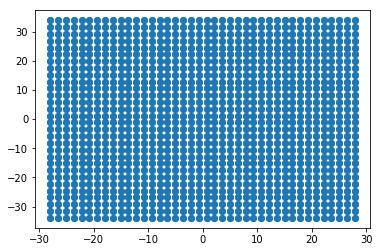

In [3]:
# plot original positions of atoms in system
plt.plot(fcc_system.atoms.pos[:, 0], fcc_system.atoms.pos[:, 1], 'o')
plt.show()

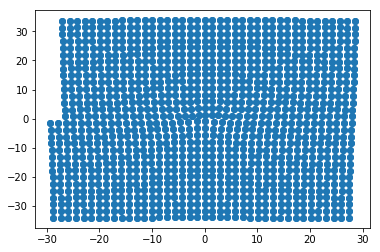

In [4]:
# plot original positions of atoms in system
plt.plot(fcc_disl_system.atoms.pos[:, 0], fcc_disl_system.atoms.pos[:, 1], 'o')
plt.show()

## 2. Slip vector

The slip vector is useful for characterizing the path that dislocations have moved between a current state and a reference state.  It characterizes how much crystal slip happens between every atom and their nearest neighbors.  The burgers vector of any moving dislocation can be estimated by looking at the magnitude and direction of the slip vector of any atoms that the dislocation passed by. The slip vector was originally outlined in [Zimmerman, et. al, Phys Rev Lett 87, 165507 ](http://dx.doi.org/10.1103/PhysRevLett.87.165507).

$$ S_{i \alpha} = -\sum_{\beta=1}^{n_{\alpha}} {\left( x_{i \alpha \beta} - X_{i \alpha \beta} \right)} $$

where $n_{\alpha}$ is the number of nearest neighbor atoms $\beta$ of atom $\alpha$, $x_{i \alpha \beta}$ is the vector difference between atoms $\alpha$ and $\beta$ in the current (defect) configuration, and $X_{i \alpha \beta}$ is the vector difference between atoms $\alpha$ and $\beta$ in the reference (perfect crystal) configuration.

**Note**: To be general with any crystal and dislocation, the slip vector computed here is *not* scaled by the number of slipped neighbors like it is in the original formulation. To estimate the Burgers vector for a moving dislocation, divide the slip vector values by the number of neighbors across the slipped plane.

### 2.1 slip_vector()

Parameters
    
- **system_0** (*atomman.system*) The base/reference system to use.

- **system_1** (*atomman.system*) The defect/current system to use.

- **neighbors** (*atomman.NeighborList, optional*) The neighbor list associated with system_0 to use.  Either neighbors or cutoff must be given, or system_0 must have a neighbors attribute.

- **cutoff** (*float, optional*) Cutoff distance for computing a neighbor list for system_0.  Either neighbors or cutoff must be given, or system_0 have a neighbors attribute.
    
Returns
    
- (*numpy.ndarray*) The computed slip vectors.

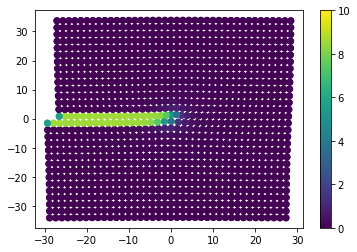

burgers ≈ 2.8643383992622238 Å


In [5]:
# Make reference system's pbc match defect system's pbc
# This avoids free surfaces having large slip vectors
fcc_system.pbc = (False, False, True)

# Compute slip vector for all atoms
neighbors0 = fcc_system.neighborlist(cutoff=0.9*alat)
slip = am.defect.slip_vector(fcc_system, fcc_disl_system, neighbors=neighbors0)

# plot slip vector magnitude for all atoms
plt.scatter(fcc_disl_system.atoms.pos[:, 0], fcc_disl_system.atoms.pos[:, 1], c=np.linalg.norm(slip, axis=1), vmin=0, vmax=10)
plt.colorbar()
plt.show()

# Compute max slip vector
maxslip = np.linalg.norm(slip, axis=1).max()

# For fcc (111) planes, three neighbor atoms "slip". 
# Divide slip vector by 3 to estimate burgers
print('burgers ≈', uc.get_in_units(maxslip / 3, 'Å'), 'Å')

## 3. Disregistry

The disregistry, $\delta_i$ characterizes the planar spreading of a dislocation in direction $\xi$ along a slip plane by measuring the difference in the displacements between the atomic planes of atoms just above, $u_i^+$, and below, $u_i^-$, the mathematical slip plane.  The displacements are taken relative to a perfect crystal base configuration.

$$ \delta_i(\xi) = u_i^+(\xi) - u_i^-(\xi)$$

The algorithm used by atomman does the following:

1. Uses the base configuration to identify all atoms in the two atomic planes neighboring the slip plane.

2. For all atoms identified in #1, finds the unique $\xi$ coordinates from the base configuration and computes $u_i^+$ and $u_i^-$ for the defect configuration relative to the base configuration.

3. Any $u_i^+$ or $u_i^-$ corresponding to the same $\xi$ coordinates are averaged, and the values of $u_i^+$ and $u_i^-$ are linearly interpolated to all unique $\xi$ coordinates. This is done as the $\xi$ coordinates may differ for the two atomic planes. 

4. The disregistry is computed for all unique $\xi$ coordinates by finding the difference in the interpolated $u_i^+$ and $u_i^-$ displacements.

### 3.1 disregistry()

Parameters

- **basesystem** (*atomman.System*) A perfect reference system with atoms directly corresponding to atoms in dislsystem.

- **dislsystem** (*atomman.System*) A dislocation-containing system.

- **spreadvector** (*array-like object, optional*) Unit vector defining the direction associated with the planar spreading along the slip plane.  Default value is [1, 0, 0] (Cartesian x-coordinates).

- **planenormal** (*array-like object, optional*) Unit vector defining the normal to the slip plane.  Must be perpendicular to xvector.  Default value is [0, 1, 0] (Cartesian y-axis).

- **planepos** (*array-like object, optional*) A position on the slip plane so that the plane can be fully defined.  The slip plane position should fall between two planes of atoms.  Default value is [0,0,0].
    
Returns
   
- **coord** (*numpy.ndarray*) The (N,) array of unique coordinates (atomic columns) neighboring the slip plane.

- **disregistry** (*numpy.ndarray*) A (N, 3) array of the dislocation's disregistry at each x.

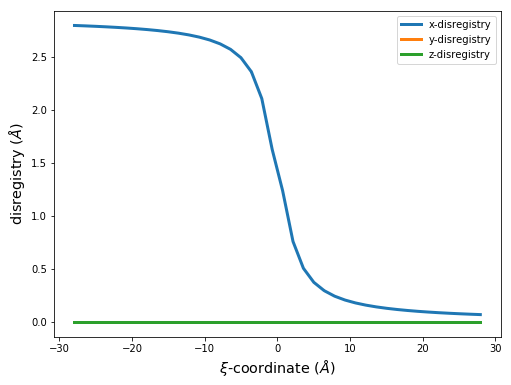

In [6]:
xi, disreg = am.defect.disregistry(fcc_system, fcc_disl_system)

fig = plt.figure(figsize=(8,6))

plt.plot(xi, disreg[:, 0], label='x-disregistry', linewidth=3)
plt.plot(xi, disreg[:, 1], label='y-disregistry', linewidth=3)
plt.plot(xi, disreg[:, 2], label='z-disregistry', linewidth=3)

plt.xlabel('$\\xi$-coordinate ($\AA$)', size='x-large')
plt.ylabel('disregistry ($\AA$)', size='x-large')
plt.legend(fontsize='xx-large')

plt.legend()
plt.show()

## 3. Nye tensor

The nye_tensor() function computes per-atom strain states and Nye tensors by comparing the local environment around each atom in a defect system to corresponding local environments in defect-free systems.  The algorithm used here follows the one outlined in [Hartley, C. & Mishin, Y. (2005). Acta Materialia 53, 1313-1321.](http://dx.doi.org/10.1016/j.actamat.2004.11.027) and [Hartley, C. S. & Mishin, Y. (2005). Materials Science and Engineering: A 400-401, 18-21.](http://dx.doi.org/10.1016/j.msea.2005.03.076), as well as code obtained from Yuri Mishin. 

The local environment around each atom $\alpha$ is characterized using a list of the position vector differences between the atom and all neighboring atoms within a cutoff distance.

- $p_{i \alpha \beta}$ is the vector difference in the defect-free reference system between atom $\alpha$ and a neighboring atom identified in the reference system, $\beta$.

- $q_{i \alpha \gamma}$ is the vector difference in the defect system between atom $\alpha$ and a neighboring atom identified in the defect system, $\gamma$.

The list of $\beta$ and $\gamma$ neighbors may differ, so $p_{i \alpha \gamma}$ vectors must be identified by uniquely pairing as many of the $p_{i \alpha \beta}$ vectors to $q_{i \alpha \gamma}$ vectors based on their directions and magnitudes.  Using the pairs, a strain correspondence tensor, $G_{ij \alpha}$, is computed as a least squares solution of the linear matrix equation

$$ q_{i \alpha \gamma} = p_{j \alpha \gamma} G_{ij \alpha}$$

Various strain properties can then be computed using $G_{ij \alpha}$:

- strain state

$$ E_{ij \alpha} = \frac{(\delta_{ij} - G_{ij \alpha}) + (\delta_{ij} - G_{ji \alpha})}{2} $$

- strain invariants

$$ I_{1 \alpha} = E_{11 \alpha} + E_{22 \alpha} + E_{33 \alpha} $$
    
$$ I_{2 \alpha} = E_{11 \alpha} E_{22 \alpha} + E_{11 \alpha} E_{33 \alpha} + E_{22 \alpha} E_{33 \alpha} - E_{12 \alpha}^2 - E_{13 \alpha}^2 - E_{23 \alpha}^2 $$
    
$$ I_{3 \alpha} = \det{E_{ij \alpha}} $$
    
- angular velocity

$$ R_{ij \alpha} = \frac{(\delta_{ij} - G_{ij \alpha}) - (\delta_{ij} - G_{ji \alpha})}{2} $$
    
$$ \omega_{\alpha} = \sqrt{R_{12 \alpha}^2 + R_{13 \alpha}^2 + R_{23 \alpha}^2} $$

The Nye tensor, $N_{ij \alpha}$, is related to $G_{i j \alpha}$ as

$$ N_{km \alpha} = - \epsilon_{ijk} \partial_i G_{m j \alpha} $$

The derivatives of $G_{i j \alpha}$ are obtained numerically by comparing the change in the strain correspondence tensor between each atom $\alpha$ and its neighbors $\gamma$. A single value for each deriviative is obtained by least squares fits of the following equations 

$$ G_{i j \gamma} - G_{i j \alpha} = q_{k \alpha \gamma} \partial_k G_{i j \alpha} $$


__Note__ that the equations in the original papers on the atomistic Nye tensor method had a typo with indicies. This function has been verified as producing comparable results as the original calculation code used by the authors.    

### 3.1. Define p_vectors

The Nye tensor calculation requires a list of reference radial neighbor vectors for each atom. For best results, these should correspond to a perfect crystal in the same/similar orientation as the defect system being analyzed.

- If all atom sites in the perfect crystal are symmetrically equivalent, then only one set of p_vectors is needed and is used for all atoms.

- Otherwise, a p_vector list needs to be specified for each atom individually based on its perfect crystal site.

Some examples:

- Body-centered cubic and face-centered cubic cells only have atoms occupying one unique lattice site.

- Hexagonal close packed has two unique sites. With A/B basal plane stacking, all atoms in A planes are identical sites and all atoms in B planes are identical sites. 

- Diamond cubic likewise has two unique sites: the face-centered cubic sites, and the sites in between.

In [7]:
# Define p_vectors for fcc cubic (standard reference frame)
p_vectors = alat * np.array([[ 0.5, 0.5, 0.0], [ 0.5, 0.0, 0.5], [ 0.0, 0.5, 0.5],
                             [-0.5, 0.5, 0.0], [-0.5, 0.0, 0.5], [ 0.0,-0.5, 0.5],
                             [ 0.5,-0.5, 0.0], [ 0.5, 0.0,-0.5], [ 0.0, 0.5,-0.5],
                             [-0.5,-0.5, 0.0], [-0.5, 0.0,-0.5], [ 0.0,-0.5,-0.5]])

print(p_vectors)

[[ 2.025  2.025  0.   ]
 [ 2.025  0.     2.025]
 [ 0.     2.025  2.025]
 [-2.025  2.025  0.   ]
 [-2.025  0.     2.025]
 [ 0.    -2.025  2.025]
 [ 2.025 -2.025  0.   ]
 [ 2.025  0.    -2.025]
 [ 0.     2.025 -2.025]
 [-2.025 -2.025  0.   ]
 [-2.025  0.    -2.025]
 [ 0.    -2.025 -2.025]]


The p_vectors must be transformed to match the orientation of the defect system. This can either be done before calling nye_tensor() as shown here, or by using the axes parameter of the nye_tensor() function.

In [8]:
# Transformed p_vectors
trans_p_vectors = np.inner(p_vectors, am.tools.axes_check([xaxis, yaxis, zaxis]))
trans_p_vectors[np.isclose(trans_p_vectors, 0)] = 0.0
print(trans_p_vectors)

[[ 1.43189123  2.33826859 -0.82670279]
 [ 0.          2.33826859  1.65340558]
 [-1.43189123  2.33826859 -0.82670279]
 [-1.43189123  0.         -2.48010836]
 [-2.86378246  0.          0.        ]
 [-1.43189123  0.          2.48010836]
 [ 1.43189123  0.          2.48010836]
 [ 2.86378246  0.          0.        ]
 [ 1.43189123  0.         -2.48010836]
 [-1.43189123 -2.33826859  0.82670279]
 [ 0.         -2.33826859 -1.65340558]
 [ 1.43189123 -2.33826859  0.82670279]]


### 3.2 nye_tensor_p()
For convenience, the atomman.defect.nye_tensor_p() function can be used to generate p_vector lists for all atoms using a base reference system.  The reference system should directly correspond to the system that the nye_tensor() calculation will be performed on, but be a perfect defect-free crystal with all periodic boundaries.

Parameters
   
- **system** (*atomman.system*) The base/reference system to use.  This should be a defect-free  perfect crystal system with atom ids directly corresponding to atoms in any system that you want to analyze with the Nye tensor.

- **neighbors** (*atomman.NeighborList, optional*) The neighbor list associated with system to use.  Either neighbors or cutoff must be given, or system must have a neighbors attribute.

- **cutoff** (*float, optional*) Cutoff distance for computing a neighbor list for system.  Either neighbors or cutoff must be given, or system have a neighbors attribute.
    
Returns

- (*numpy.ndarray*) The list of p distance vectors for each atom in system.

In [9]:
# Make reference system's pbc all periodic
fcc_system.pbc = (True, True, True)

# Build p_vectors
neighbors0 = fcc_system.neighborlist(cutoff=alat*0.9)
all_p_vectors = am.defect.nye_tensor_p(fcc_system, neighbors=neighbors0)

# Show length of all_p_vectors to be natoms
print(fcc_system.natoms)
print(len(all_p_vectors))

# Show that first p_vectors list matches p_vectors above, besides order
first_p_vectors = all_p_vectors[0]
first_p_vectors[np.isclose(first_p_vectors, 0)] = 0.0
print(first_p_vectors)

2400
2400
[[-1.43189123  0.         -2.48010836]
 [-2.86378246  0.          0.        ]
 [-1.43189123  0.          2.48010836]
 [ 0.          2.33826859  1.65340558]
 [-1.43189123  2.33826859 -0.82670279]
 [ 2.86378246  0.          0.        ]
 [ 1.43189123  0.          2.48010836]
 [ 1.43189123  0.         -2.48010836]
 [ 1.43189123  2.33826859 -0.82670279]
 [ 0.         -2.33826859 -1.65340558]
 [-1.43189123 -2.33826859  0.82670279]
 [ 1.43189123 -2.33826859  0.82670279]]


### 3.3 nye_tensor()

Parameters
    
- **system** (*atomman.System*) The atomic system to compute the per-atom strain properties and Nye tensor for.

- **p_vectors** (*array-like object*) List(s) of radial distance vectors between each atom and its nearest neighbors in a perfect crystal setting.  If one list of p_vectors is given, then it is applied to all atoms.

- **theta_max** (*float, optional*) The maximum theta angle in degrees to use when searching for matches between p vectors and q vectors.  Optimum values are dependent on the crystal structure. Default value is 27, which is the original value used for fcc crystals.

- **axes** (*array-like object, optional*) 3x3 array of right-handed orthogonal axes.  If given, will be used to transform the p_vectors before computing the Nye tensor.

- **neighbors** (*atomman.NeighborList, optional*) The neighbor list associated with system to use.  Either neighbors or cutoff must be given, or system must have a neighbors attribute.

- **cutoff** (*float*) Cutoff distance for computing a neighbor list for system.  Either neighbors or cutoff must be given, or system have a neighbors attribute.
    
Returns
    
- (*dict*) Contains the per-atom properties 'strain', 'strain_invariant_1', 'strain_invariant_2', 'strain_invariant_3', 'angular_velocity', and 'Nye_tensor'.

In [10]:
neighbors = fcc_disl_system.neighborlist(cutoff = 0.9*alat)

In [11]:
# Compute strain values and Nye tensor
nye_dict = am.defect.nye_tensor(fcc_disl_system, p_vectors, axes=[xaxis, yaxis, zaxis], neighbors=neighbors)

# Save results to fcc_disl_system as per-atom properties
for key in nye_dict:
    fcc_disl_system.atoms.view[key] = nye_dict[key]

### 3.4 interpolate_contour()

The atomman.plot.interpolate_contour() function generates a pretty-looking contour plot of a per-atom property by interpolating values between the atoms.  This provides a mapping of the per-atom properties as pseudo-continuum properties.

Parameters
    
- **system** (*atomman.System*) The system with the per-atom property that you want to plot.

- **name** (*str*) The name of the per-atom property that you want to plot.

- **property** (*array-like object, optional*) Values for the per-atom property to plot.  If not given, values will be taken as the "name" property of system.

- **index** (*int or tuple, optional*) Specifies which component of a multidimensional property to plot.  Not needed if the property is scalar.

- **magnitude** (*bool, optional*) If True, plots the per-atom magnitude of a vector property.  Cannot be combined with index.  Default value is False.

- **plotxaxis** (*str or array-like object, optional*) Indicates the Cartesian direction associated with the system's atomic coordinates to align with the plotting x-axis.  Values are either 3D unit vectors, or strings 'x', 'y', or 'z' for the Cartesian axes directions.  plotxaxis and plotyaxis must be orthogonal.  Default value is 'x' = [1, 0, 0].

- **plotyaxis** (*str or array-like object, optional*) Indicates the Cartesian direction associated with the system's atomic coordinates to align with the plotting y-axis.  Values are either 3D unit vectors, or strings 'x', 'y', or 'z' for the Cartesian axes directions.  plotxaxis and plotyaxis must be orthogonal.  Default value is 'y' = [0, 1, 0].

- **xlim** (*tuple, optional*) The minimum and maximum coordinates along the plotting x-axis to include in the fit.  Values are taken in the specified length_unit.  If not given, then the limits are set based on min and max atomic coordinates along the plotting axis.

- **ylim** (*tuple, optional*) The minimum and maximum coordinates along the plotting y-axis to include in the fit.  Values are taken in the specified length_unit.  If not given, then the limits are set based on min and max atomic coordinates along the plotting axis.

- **zlim** (*tuple, optional*) The minimum and maximum coordinates normal to the plotting axes (i.e. plotxaxis X plotyaxis) to include in the fit.  Values are taken in the specified length_unit.  If not given, then the limits are set based on min and max atomic coordinates along the axis.

- **xbins** (*int, optional*) Specifies the number of interpolation bins to use along the plotting x-axis.  Default value is 200.

- **ybins** (*int, optional*) Specifies the number of interpolation bins to use along the plotting y-axis.  Default value is 200.

- **dots** (*bool, optional*) If True, then the positions of the atoms are shown as circles.  Default value is True.

- **czero** (*bool, optional*) If True, the range of property values will be centered around zero, i.e. cmax = -cmin.  If False, cmax and cmin will be independently selected using the property values.  Default value is True.

- **save** (*bool, optional*) If True, the generated plot will be saved to "name.png".  Default value is False.

- **show** (*bool, optional*) If True, matplotlib.pyplot.show() is called.  Default value is True.

- **length_unit** (*str, optional*) The units of length to use for the plotting x- and y-axes.  Default value is 'angstrom'.

- **property_unit** (*str or None, optional*) The units to use for the property value being plotted.  Default value is None, in which no unit conversion is applied.

- **cmap** (*str, optional*) The name of the matplotlib colormap to use.  Default value is 'jet'.
    
Returns

- **intsum** (*float*) The area integrated sum of the property over the plotted region.
- **avsum** (*float*) The average property value taken across all plotting bins.

**NOTE:** The strain and Nye tensor values shown here are only for demonstration purposes and should *not* be used as there has been no atomic relaxations.

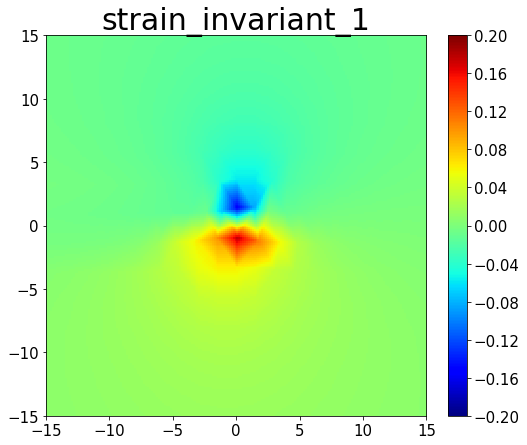

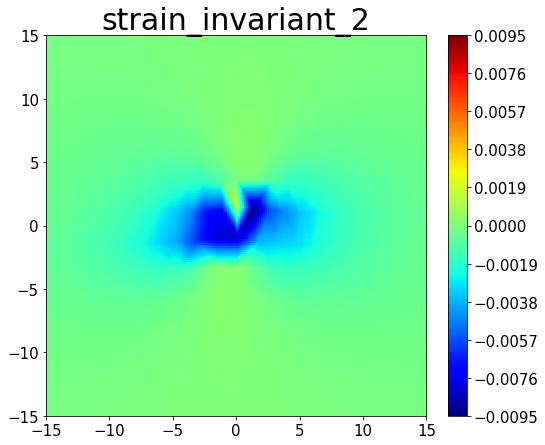

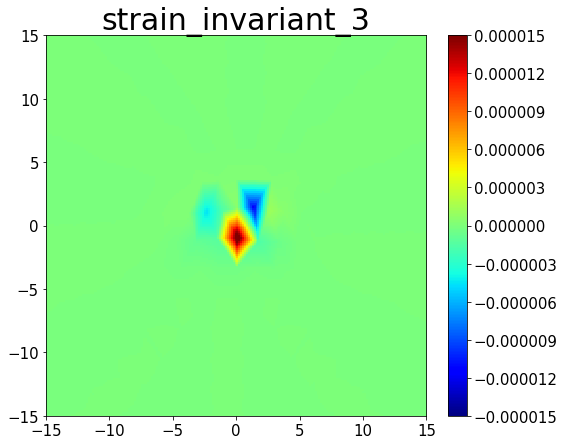

In [12]:
# Make contour plots for the strain invariants
intsum, avsum = am.plot.interpolate_contour(fcc_disl_system, 'strain_invariant_1',
                                            xlim=(-15,15), ylim=(-15,15), dots=False)

intsum, avsum = am.plot.interpolate_contour(fcc_disl_system, 'strain_invariant_2',
                                            xlim=(-15,15), ylim=(-15,15), dots=False)

intsum, avsum = am.plot.interpolate_contour(fcc_disl_system, 'strain_invariant_3',
                                            xlim=(-15,15), ylim=(-15,15), dots=False)

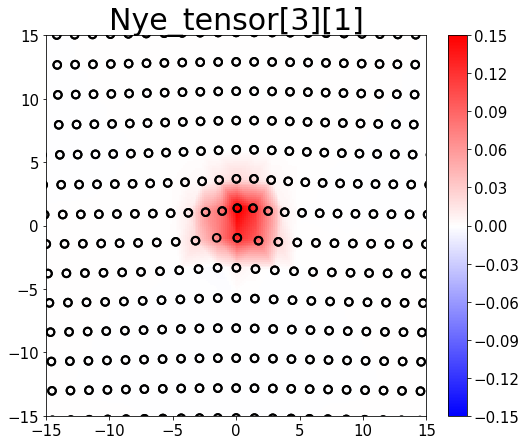

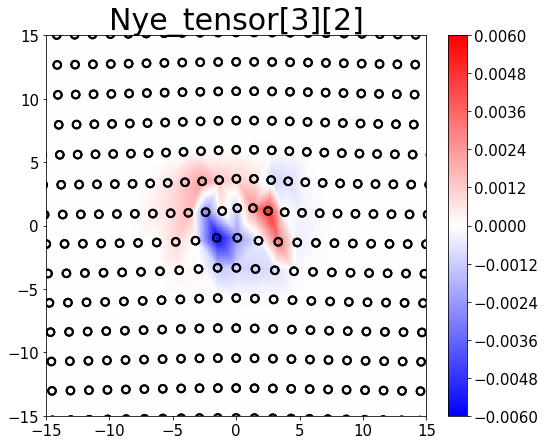

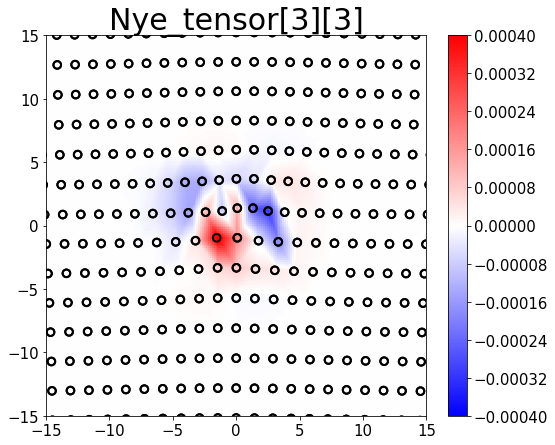

In [13]:
# plot Nye tensor components related to dislocations
intsum = np.empty(3)
intsum[0], avsum = am.plot.interpolate_contour(fcc_disl_system, 'Nye_tensor', index = [2,0],
                                               xlim=(-15,15), ylim=(-15,15), cmap='bwr')

intsum[1], avsum = am.plot.interpolate_contour(fcc_disl_system, 'Nye_tensor', index = [2,1],
                                               xlim=(-15,15), ylim=(-15,15), cmap='bwr')

intsum[2], avsum = am.plot.interpolate_contour(fcc_disl_system, 'Nye_tensor', index = [2,2],
                                               xlim=(-15,15), ylim=(-15,15), cmap='bwr')

Burgers vector estimate is obtained from the integer sums over the plots

In [14]:
print('Integration summation estimate of Burgers vector = [%f, %f, %f]' % tuple(intsum))

Integration summation estimate of Burgers vector = [2.986842, 0.005223, -0.000769]


## 4. Differential displacement plot

Dislocation core structures can also be characterized using differential displacement plots. For every pair of neighboring atoms $\alpha$ and $\beta$, a differential displacement vector, $d_{i \alpha \beta}$ is computed as

$$ d_{i \alpha \beta} =  x_{i \alpha \beta} - X_{i \alpha \beta} $$

where $x_{i \alpha \beta}$ is the vector difference between atoms $\alpha$ and $\beta$ in the current (defect) configuration, and $X_{i \alpha \beta}$ is the vector difference between atoms $\alpha$ and $\beta$ in the reference (perfect crystal) configuration.   Plots are then constructed where arrows representing components of the differential displacement vectors are positioned halfway between the corresponding atoms.

Two component styles are currently supported

- **'standard'** The classic differential displacement representation that works for all dislocation types.  The arrows are oriented to point between atoms $\alpha$ and $\beta$ for each pair.  The magnitudes of the arrows are taken as the component of $d_{i \alpha \beta}$ parallel to the Burgers vector, $b_i$.  Large values are adjusted such that the resulting magnitudes always fall between $\pm b_i / 2$.

- **'xy'** An alternate representation that is used for analyzing screw dislocations.  The arrows' directions and magnitudes directly show the in-plane edge components (i.e. within the plotting xy plane) of $d_{i \alpha \beta}$.

### 4.1 differential_displacement()

Parameters
   
- **system_0** (*atomman.system*) The base/reference system to use.

- **system_1** (*atomman.system*) The defect/current system to use.

- **burgers** (*array-like object*) The dislocation's Burgers vector.

- **plotxaxis** (*str or array-like object, optional*) Indicates the Cartesian direction associated with the system's atomic coordinates to align with the plotting x-axis.  Values are either 3D unit vectors, or strings 'x', 'y', or 'z' for the Cartesian axes directions.  plotxaxis and plotyaxis must be orthogonal.  Default value is 'x' = [1, 0, 0].

- **plotyaxis** (*str or array-like object, optional*) Indicates the Cartesian direction associated with the system's atomic coordinates to align with the plotting y-axis.  Values are either 3D unit vectors, or strings 'x', 'y', or 'z' for the Cartesian axes directions.  plotxaxis and plotyaxis must be orthogonal.  Default value is 'y' = [0, 1, 0].

- **xlim** (*tuple, optional*) The minimum and maximum coordinates along the plotting x-axis to include in the fit.  Values are taken in the specified length_unit.  If not given, then the limits are set based on min and max atomic coordinates along the plotting axis.

- **ylim** (*tuple, optional*) The minimum and maximum coordinates along the plotting y-axis to include in the fit.  Values are taken in the specified length_unit. If not given, then the limits are set based on min and max atomic coordinates along the plotting axis.

- **zlim** (*tuple, optional*) The minimum and maximum coordinates normal to the plotting axes (i.e. plotxaxis X plotyaxis) to include in the fit.  Values are taken in the specified length_unit.  The optimum zlim should encompass only a single periodic slice. If not given, then the limits are set based on min and max atomic coordinates along the axis.

- **neighbors** (*atomman.NeighborList, optional*) The neighbor list associated with system_0 to use.  Either neighbors or cutoff must be given, or system_0 must have a neighbors attribute.

- **cutoff** (*float, optional*) Cutoff distance for computing a neighbor list for system_0.  Either neighbors or cutoff must be given, or system_0 have a neighbors attribute.

- **component** (*str, optional*) Indicates the style of the calculation to use:
        
    - 'standard' (default) plots the differential displacements between atoms in the Burgers direction.
    
    - 'xy' plots the differential displacements within the xy plotting plane.  This is useful for screw dislocations with localized non-screw components.
    
- **axes** (*arraly-like object, optional*) 3x3 transformation array to apply to the Burgers vector to make it correspond to the system's orientation.

- **plot_scale** (*float, optional*) Scalar for multiplying the magnitude of the differential displacement arrows.  Default value is 1 (no scaling).

- **atom_color** (*str or list, optional*) Matplotlib color name(s) to use to display the atoms.  If str, that color will be assigned to all atypes.  If list, must give a color value or None for each atype.  Default value (None) will use cmap instead.  Note: atom_color and atom_cmap can be used together as long as exactly one color or cmap is given for each unique atype.

- **atom_cmap** (*str or list, optional*) Matplotlib colormap name(s) to use to display the atoms.  Atoms will be colored based on their initial positions and scaled using zlim. If str, that cmap will be assigned to all atypes.  If list, must give a cmap value or None for each atype.  Default value (None) will use 'hsv' cmap.  Note: atom_color and atom_cmap can be used together as long as exactly one color or cmap is given for each unique atype.

- **display_final_pos** (*bool, optional*) Flag to display positions of atoms and arrows relative to final configuration (system_1) rather than initial configuration (system_0). Note that this does not affect the atom's cmap color as the initial plotzaxis is always used.

- **return_data** (*bool, optional*) If True, will return a dict containing the differential displacement vectors and vector positions.  Default is False.  Note: returned values are oriented relative to the plotting axes.

Returns

- **fig** (*matplotlib.figure*) The generated figure.

- **data** (*dict*) Contains differential displacement vectors and arrow plotting information.  Returned if return_data is True.

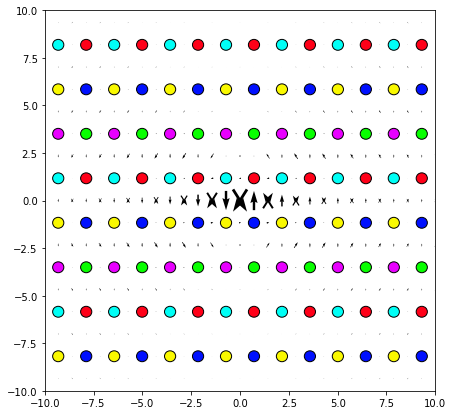

In [15]:
# Make boundaries match defect system to avoid large differential displacements
fcc_system.pbc = (False, False, True)

# Specify plot limits
xlim= (-10, 10)
ylim= (-10, 10)

# zlim should encompass a single periodic z section
zlim= (-0.01, alat * 6**0.5 / 2 + 0.01)
fig, data = am.defect.differential_displacement(fcc_system, fcc_disl_system, burgers, axes=[xaxis, yaxis,zaxis],
                                          cutoff = 0.9*alat, xlim=xlim, ylim=ylim, zlim=zlim,
                                          return_data=True)

In [16]:
data

{'centers': array([[-12.17107547, -14.02961154,   1.65340558],
        [-12.88702109, -14.02961154,   2.89345976],
        [-11.45512986, -14.02961154,   2.89345976],
        ...,
        [ 11.45512986,  14.02961154,   2.89345976],
        [ 12.88702109,  14.02961154,   2.89345976],
        [ 12.17107547,  14.02961154,   4.13351394]]),
 'vectors': array([[ 3.25526312e-02,  1.59160356e-02, -8.04003278e-04],
        [ 1.14509606e-02, -6.91577561e-03, -1.13217377e-05],
        [ 5.35091799e-02,  3.99477258e-02, -1.35336464e-03],
        ...,
        [ 5.35091799e-02,  3.99477258e-02, -1.35336464e-03],
        [ 1.14509606e-02, -6.91577561e-03, -1.13217377e-05],
        [ 3.25526312e-02,  1.59160356e-02, -8.04003278e-04]])}

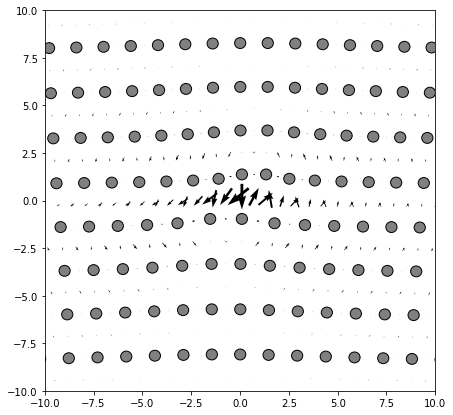

In [17]:
# Make boundaries match defect system to avoid large differential displacements
fcc_system.pbc = (False, False, True)

# Specify plot limits
xlim= (-10, 10)
ylim= (-10, 10)

# zlim should encompass a single periodic z section
zlim= (-0.01, alat * 6**0.5 / 2 + 0.01)
fig = am.defect.differential_displacement(fcc_system, fcc_disl_system, burgers, axes=[xaxis, yaxis,zaxis],
                                          cutoff = 0.9*alat, xlim=xlim, ylim=ylim, zlim=zlim,
                                          atom_color='gray', display_final_pos=True)

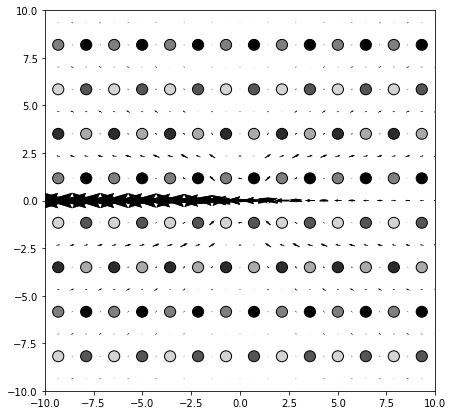

In [18]:
fig = am.defect.differential_displacement(fcc_system, fcc_disl_system, burgers, axes=[xaxis, yaxis,zaxis],
                                          cutoff = 0.9*alat, xlim=xlim, ylim=ylim, zlim=zlim, 
                                          atom_cmap='binary', component='xy')